# Persistent Homology on Health Centers in California

This Jupyter Notebook is based of the Jupyter Notebook Produced in "Persistent Homology for Resource Coverage: A Case Study of Access to Polling Sites"
DOI: 10.1137/22M150410X
Link to repository: https://bitbucket.org/jerryluo8/coveragetda/src/main/

In [ ]:
# from google.colab import drive, files
# drive.mount('/content/drive')
# pathname = "/content/drive/Shared with me/TDA for Resource Access/"
# import sys
# sys.path.append(pathname)

### Installing necessary packages

In [114]:
%pip install contextily
%pip install cartopy
%pip install geopandas
%pip install gudhi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Calling in Packages

In [ ]:
import numpy as np
import gudhi as gd
from gudhi import RipsComplex
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#### Applying functions from the Gudhi Library

In [ ]:
# This file is part of the Gudhi Library - https://gudhi.inria.fr/ - which is released under MIT.
# See file LICENSE or go to https://gudhi.inria.fr/licensing/ for full license details.
# Author(s):       Vincent Rouvreau, Bertrand Michel
#
# Copyright (C) 2016 Inria
#
# Modification(s):
#   - 2020/02 Theo Lacombe: Added more options for improved rendering and more flexibility.
#   - YYYY/MM Author: Description of the modification
from os import path
from math import isfinite
import numpy as np
from functools import lru_cache

__author__ = "Vincent Rouvreau, Bertrand Michel, Theo Lacombe"
__copyright__ = "Copyright (C) 2016 Inria"
__license__ = "MIT"

_gudhi_matplotlib_use_tex = True

def __min_birth_max_death(persistence, band=0.0):
    """This function returns (min_birth, max_death) from the persistence.

    :param persistence: The persistence to plot.
    :type persistence: list of tuples(dimension, tuple(birth, death)).
    :param band: band
    :type band: float.
    :returns: (float, float) -- (min_birth, max_death).
    """
    # Look for minimum birth date and maximum death date for plot optimisation
    max_death = 0
    min_birth = persistence[0][1][0]
    for interval in reversed(persistence):
        if float(interval[1][1]) != float("inf"):
            if float(interval[1][1]) > max_death:
                max_death = float(interval[1][1])
        if float(interval[1][0]) > max_death:
            max_death = float(interval[1][0])
        if float(interval[1][0]) < min_birth:
            min_birth = float(interval[1][0])
    if band > 0.0:
        max_death += band
    return (min_birth, max_death)


def _array_handler(a):
    '''
    :param a: if array, assumes it is a (n x 2) np.array and return a
                persistence-compatible list (padding with 0), so that the
                plot can be performed seamlessly.
    '''
    if isinstance(a[0][1], np.float64) or isinstance(a[0][1], float):
        return [[0, x] for x in a]
    else:
        return a

@lru_cache(maxsize=1)
def _matplotlib_can_use_tex():
    """This function returns True if matplotlib can deal with LaTeX, False otherwise.
    The returned value is cached.
    """
    try:
        from matplotlib import checkdep_usetex
        return checkdep_usetex(True)
    except ImportError:
        print("This function is not available, you may be missing matplotlib.")

# Plotting Persistence Diagram
def plot_persistence_diagram_fixed(persistence, alpha=0.6, max_intervals=2000, legend=True):
    try:
        import matplotlib.pyplot as plt
        import matplotlib.patches as mpatches
        
        # Handle the persistence format
        if hasattr(persistence, '__iter__'):
            persistence_list = list(persistence)
        else:
            persistence_list = persistence
            
        if not persistence_list:
            print("No persistence intervals found!")
            return
            
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Get min/max values for plotting
        finite_intervals = [(dim, birth, death) for dim, (birth, death) in persistence_list 
                        if death != float('inf')]
        
        if not finite_intervals:
            print("No finite intervals found!")
            return ax
            
        births = [birth for _, birth, death in finite_intervals]
        deaths = [death for _, birth, death in finite_intervals]
        
        min_val = min(min(births), min(deaths))
        max_val = max(max(births), max(deaths))
        
        # Plot diagonal
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        # Plot points by dimension
        colors = ['red', 'blue', 'green', 'orange']
        markers = ['o', 'x', 's', '^']
        
        for dim in range(2):  # 0D and 1D
            dim_intervals = [(birth, death) for d, birth, death in finite_intervals if d == dim]
            if dim_intervals:
                births, deaths = zip(*dim_intervals)
                ax.scatter(births, deaths, 
                        c=colors[dim], 
                        marker=markers[dim],
                        alpha=alpha, 
                        s=50,
                        label=f'{dim}D Homology')
        
        if legend:
            ax.legend()
            
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
        ax.set_title('Persistence Diagram')
        ax.grid(True, alpha=0.3)
        
        return ax
        
    except Exception as e:
        print(f"Error in plotting persistence diagram: {e}")
        return None

'''# Use the fixed version
plt.figure(figsize=(10, 8))
#plot_persistence_diagram_fixed(ph, legend=True)
plt.tight_layout()
plt.show()'''

<Figure size 1000x800 with 0 Axes>

### Getting Info for TDA

In [191]:
import numpy as np
import gudhi as gd
import os
from gudhi import RipsComplex
    
def get_tda_info(gdf,distance_matrix_np, max_hom_dim = 1):
    '''
    citypath: string. path where data/travel time matrices are stored. 
        In TDA for Resource Access Drive, this is one of {Atlanta, Chicago, Jacksonville, Los Angeles, NYC, Salt Lake City}.
    city: {atl, chc, jax, lac, manbronx, queensbrook, stat, slc}
    Assume that distance matrix is already computed and saved at citypath + f'/{city}_d_matrix.npy'
    '''
    # Load distance matrix and wait times (the weights for the weighted Rips complex)
    D_city = distance_matrix_np
    #np.genfromtxt(citypath + f'/{city}_d_matrix.csv', delimiter = ",")
    
    # Calculate simplex pairs for the homology classes
    cpx = RipsComplex(distance_matrix = D_city).create_simplex_tree(max_dimension = max_hom_dim + 1)
    cpx.compute_persistence()
    ph = cpx.persistence()
    all_pairs = cpx.persistence_pairs()
    return cpx, ph, all_pairs

### Death Simplices

In [ ]:
import geopandas as gpd
from shapely.geometry import LineString, Polygon
import scipy.stats
from shapely.geometry import LineString, Polygon

# ORIGINIAL 
def plot_deathsimplices_raw(gdf, distance_matrix, cpx, all_pairs, hom_dim, ax, criteria = 'lifetime', thresh = 120, citydf_fname = None, vmin0 = 0, vmin1 = 90, vmax0 = 3250, vmax1 = 3250, legend = True):
    '''
    cpx: The filtered complex, as computed by get_cpx_spxpairs. Assume ph has already been computed
    all_pairs: All (birth simplex, death simplex) pairs for the ph of cpx, as computed by get_cpx_spxpairs
    hom_dim: {0, 1}. Homology dimension.
    ax: ax to plot on. (This is passed as an argument so that we can overlay multiple death simplex plots on top of each other, e.g. for NYC)
    criteria: {'lifetime', 'death'}. For each homology class, either compute persistence/lifetime (death - birth) or just death
    thresh: (float) optional , default 0. We only consider finite criteria values for each homology class.
    vmax0: (float) optional, default 6500. we want this to be higher than the highest death filtration of 0th homology
    vmax1: (float) optional, default 8100. same thing as vmax0, but for 1st homology
    
    Plot death simplices for finite homology classes with a lifetime/persistence or death value above thresh, in dimension hom_dim.
    '''
    counties = gpd.read_file('california_counties.geojson')
    counties = counties.to_crs("EPSG:4326")  # or match your other data's CRS
    gdf = gdf.to_crs(counties.crs)
    # Get simplex pairs for homology classes in dimension hom_dim. Only get the finite homology classes (i.e., the ones that have a death simplex)
    pairs = [pair for pair in all_pairs if len(pair[1]) == hom_dim + 2]

    # Calculate criteria, sort death simplices by criteria
    if criteria == "death":
        deathspx_criteria = [[pair[1], cpx.filtration(pair[1])] for pair in pairs]
    elif criteria == "lifetime":
        deathspx_criteria = [[pair[1], cpx.filtration(pair[1]) - cpx.filtration(pair[0])] for pair in pairs]
    deathspx_criteria.sort(key = lambda row: row[1], reverse = True)
    death_simplices = [item[0] for item in deathspx_criteria]
    criteria_vals = [item[1] for item in deathspx_criteria]
    
    # Make geopandas dataframe where the polygons represent the death simplices
    if hom_dim == 0:
        df_deathsimplices = gpd.GeoDataFrame(geometry=[LineString([gdf.geometry[deathspx[j]] for j in range(2)]).buffer(0.03) for deathspx in death_simplices])
    elif hom_dim == 1:
        df_deathsimplices = gpd.GeoDataFrame(geometry=[Polygon([gdf.geometry[deathspx[j]] for j in range(3)]) for deathspx in death_simplices])
    df_deathsimplices['criteria'] = criteria_vals
    df_deathsimplices_truncated = df_deathsimplices[df_deathsimplices['criteria'] > thresh]
    # Plot
    #ax.set_axis_off()
    counties.plot(ax=ax, color='white', edgecolor='grey')
    gdf.plot(ax=ax, markersize=1, color='blue')
    
    # Plot
    #ax.set_axis_off()
    counties.plot(ax=ax, color='white', edgecolor='grey')
    gdf.plot(ax=ax, markersize=1, color='blue')

    if hom_dim == 0:
        vmin = vmin0
        vmax = vmax0
    else:
        vmin = vmin0
        vmax = vmax1
    df_deathsimplices_truncated.plot('criteria', ax=ax, alpha=0.7, vmin = vmin, vmax = vmax, legend = legend)

# Running Functions on All Locations

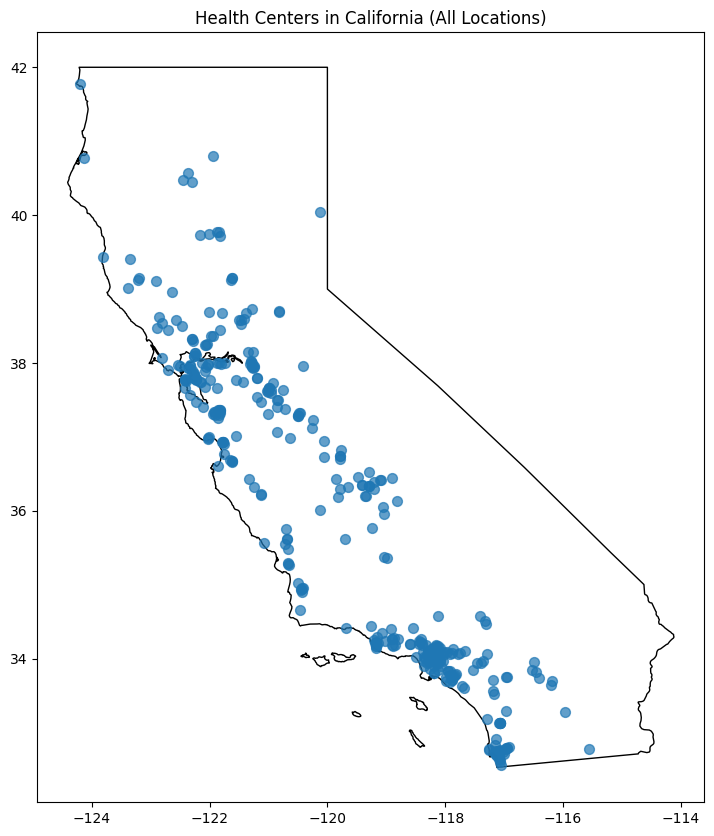

In [218]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import contextily as ctx
# Load GeoJSON
gdf = gpd.read_file('output_all.geojson')
#gdf.plot()
#plt.title("Health Centers in California")
import cartopy.io.shapereader as shpreader

shpfilename = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
states = gpd.read_file(shpfilename)
california = states[states['name'] == 'California']
california = california.to_crs("EPSG:4326")
# Load your health centers
gdf = gpd.read_file('output_all.geojson')

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
california.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, markersize=50, alpha=0.7)
ax.set_title("Health Centers in California (All Locations)")
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

distance_matrix = np.load('all_d_matrix.npy')

assert len(gdf) == distance_matrix.shape[0] == distance_matrix.shape[1], \
    "Distance matrix dimensions must match number of GeoJSON features"
# Extract coordinates (longitude, latitude) into a NumPy array
#coordinates = np.array(list(gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
# Alternative approaches:
# Method 1: Using get_coordinates() (more efficient for large datasets)
coordinates = gdf.geometry.get_coordinates().values
points = coordinates
#print(points)
# Compute unweighted Rips complex
cpx, ph, all_pairs = get_tda_info(gdf, distance_matrix,max_hom_dim=1)
# Plot persistence diagram
plt.rcParams['figure.figsize'] = (12, 10)
#fig, ax = plt.subplots(1,1)
order_criteria = 'death'
thresh = 120

### Persistence Diagram for All Locations (FQHCs + PPs)

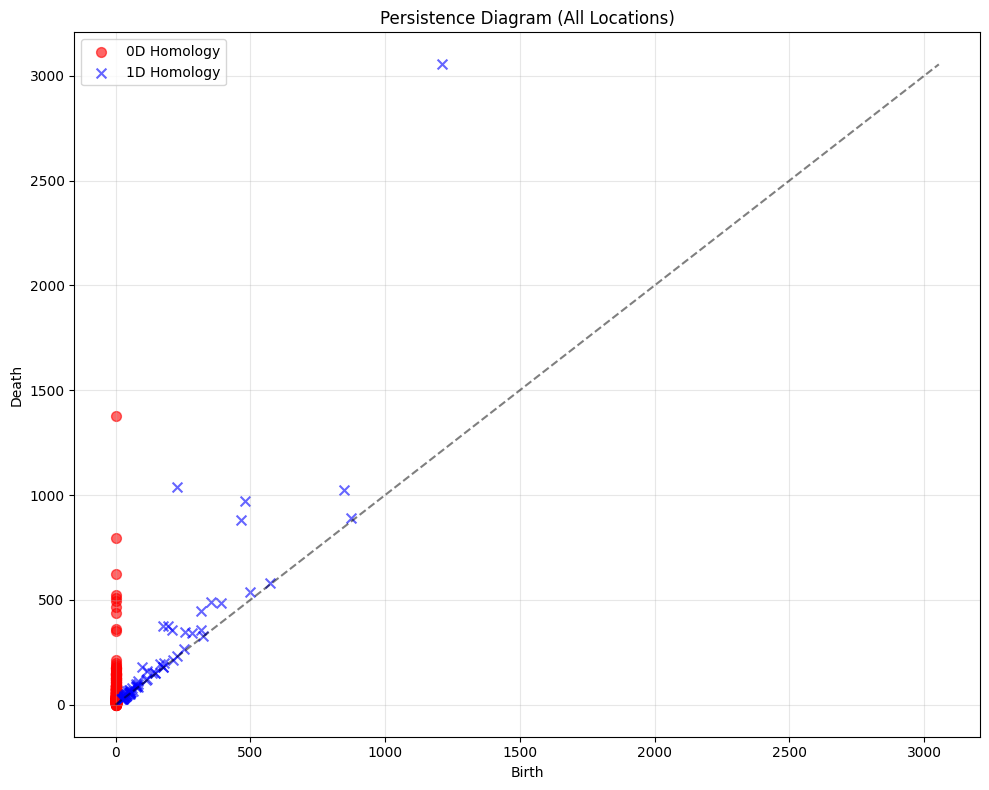

In [219]:
# 1. Plot persistence diagram
plot_persistence_diagram_fixed(ph)
plt.title(f"Persistence Diagram (All Locations)")
plt.tight_layout()
plt.show()

### All Locations 0D Death Simplices

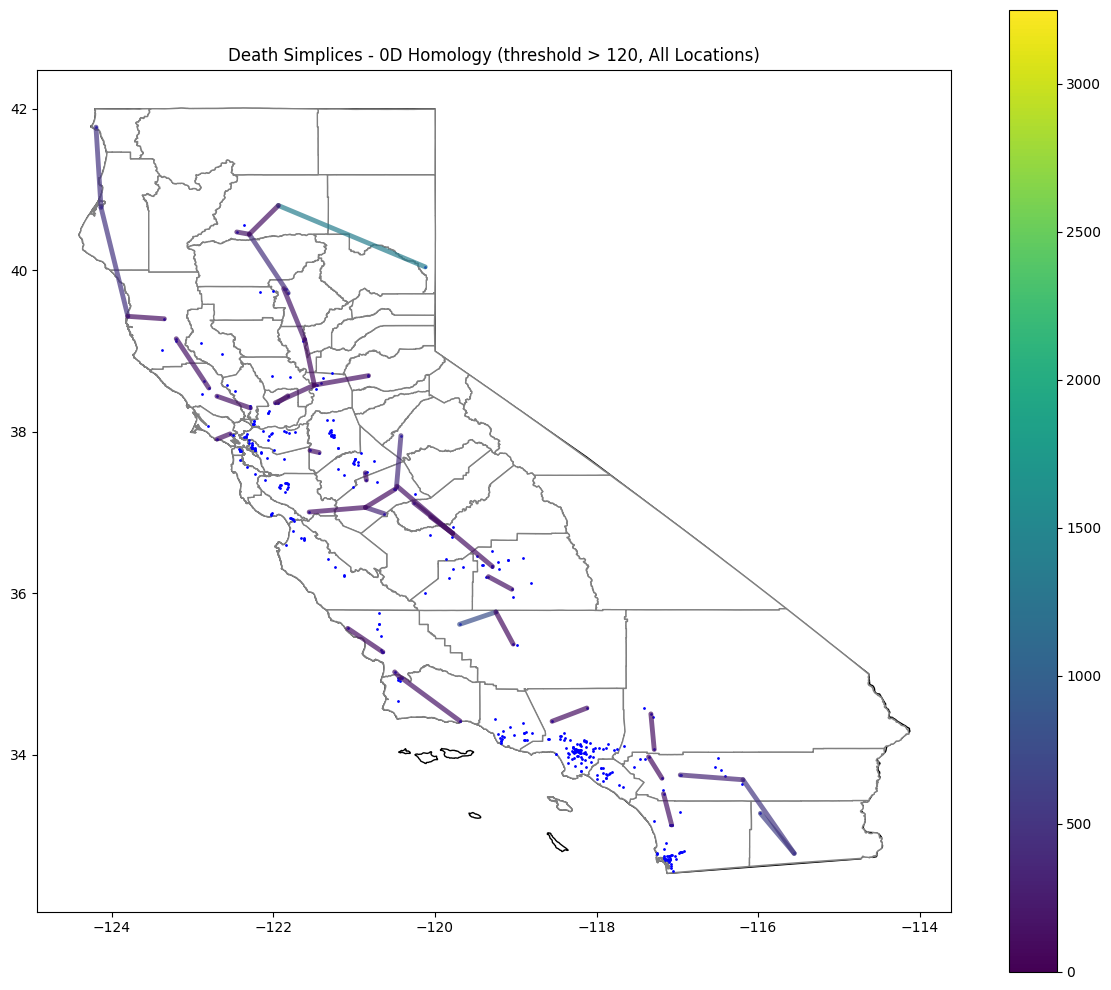

In [220]:
# 2. Plot 0D death simplices
fig, ax = plt.subplots(figsize=(12, 10))
california.plot(ax=ax, color='white', edgecolor='black')
#simple_plot_death_simplices_raw(gdf, cpx, all_pairs, hom_dim=0, ax=ax)
plt.title(f"Death Simplices - 0D Homology (threshold > {thresh}, All Locations)")
#simple_plot_death_simplices(gdf, cpx, all_pairs, hom_dim=0, ax=ax)
plot_deathsimplices_raw(gdf, distance_matrix, cpx, all_pairs, 0, ax)
plt.tight_layout()
plt.show()

### All Locations 1D Death Simplices

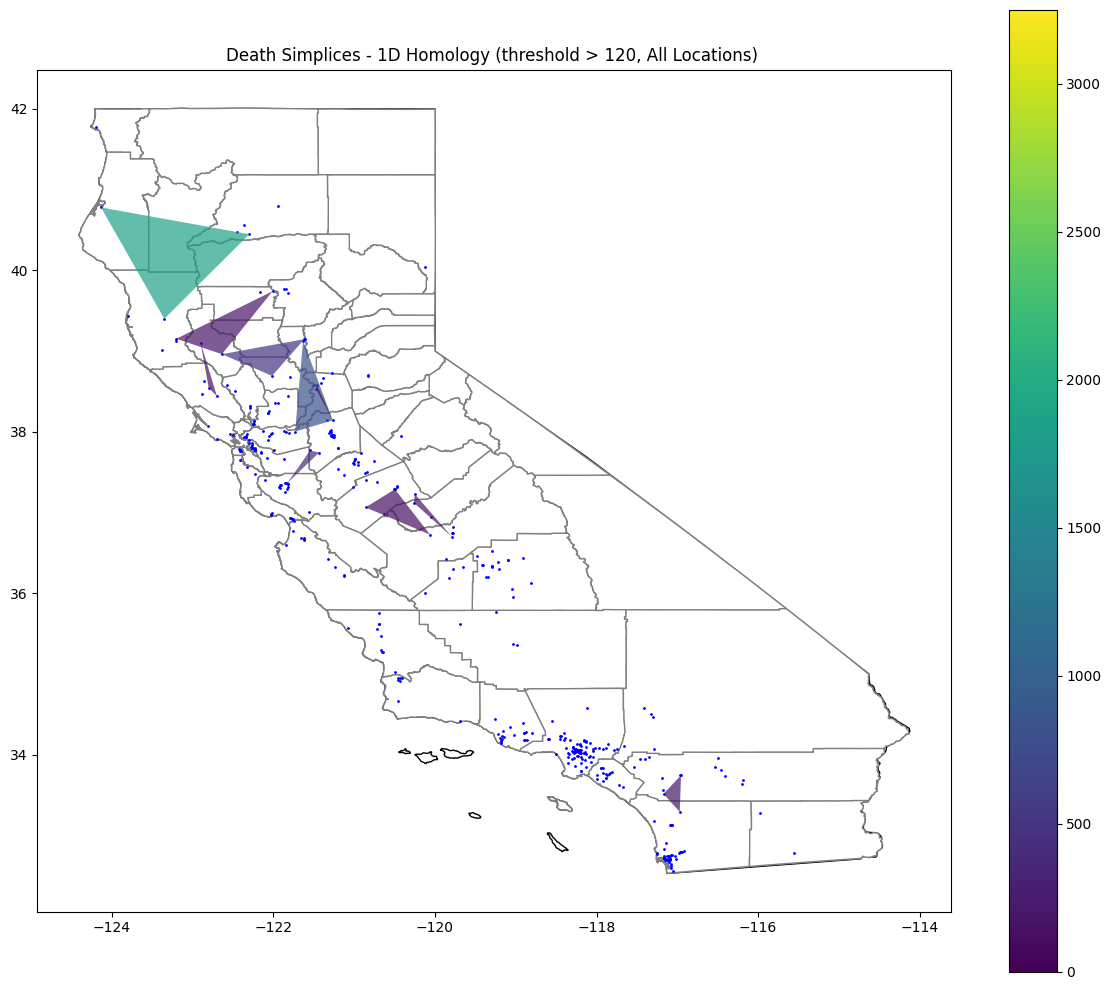

In [221]:
# 3. Plot 1D death simplices  
fig, ax = plt.subplots(figsize=(12, 10))
california.plot(ax=ax, color='white', edgecolor='black')
plot_deathsimplices_raw(gdf, distance_matrix, cpx, all_pairs, 1, ax)
plt.title(f"Death Simplices - 1D Homology (threshold > {thresh}, All Locations) ")
plt.tight_layout()
plt.show()

# Running Functions on FQHCs

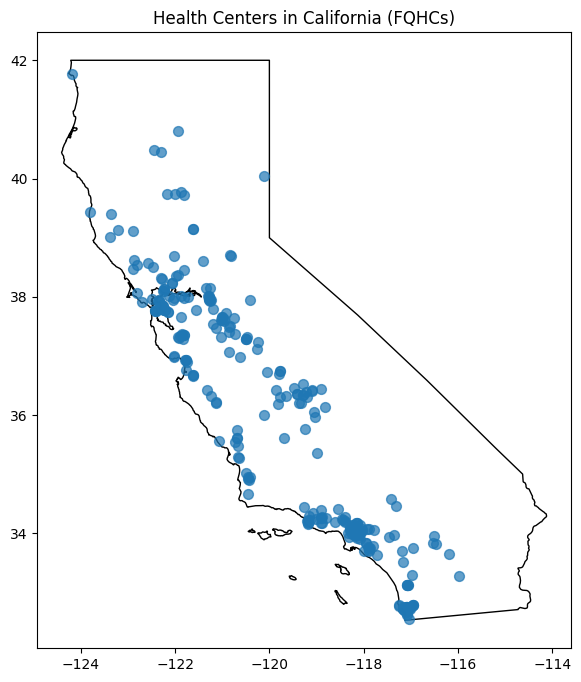

In [222]:
gdf = gpd.read_file('output_fqhc.geojson')
#gdf.plot()
#plt.title("Health Centers in California")
import cartopy.io.shapereader as shpreader

shpfilename = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
states = gpd.read_file(shpfilename)
california = states[states['name'] == 'California']
# Load your health centers
gdf = gpd.read_file('output_fqhc.geojson')

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
california.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, markersize=50, alpha=0.7)
ax.set_title("Health Centers in California (FQHCs)")
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

distance_matrix = np.load('fqhc_d_matrix.npy')

assert len(gdf) == distance_matrix.shape[0] == distance_matrix.shape[1], \
    "Distance matrix dimensions must match number of GeoJSON features"
# Extract coordinates (longitude, latitude) into a NumPy array
#coordinates = np.array(list(gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
# Alternative approaches:
# Method 1: Using get_coordinates() (more efficient for large datasets)
coordinates = gdf.geometry.get_coordinates().values
points = coordinates
#print(points)
# Compute unweighted Rips complex
cpx, ph, all_pairs = get_tda_info(gdf, distance_matrix,max_hom_dim=1)
# plotting death simplices
#plot_deathsimplices('output_all.geojson', 'all_d_matrix.npy', cpx, all_pairs, 1, , criteria = 'death', zscore_thresh = 1, citydf_fname = None, vmin0 = 3235, vmin1 = 4410, vmax0 = 7380, vmax1 = 7942, legend = False)
# Plot persistence diagram
plt.rcParams['figure.figsize'] = (10, 10)
order_criteria = 'death'
thresh = 120


### FQHC Persistence Diagram

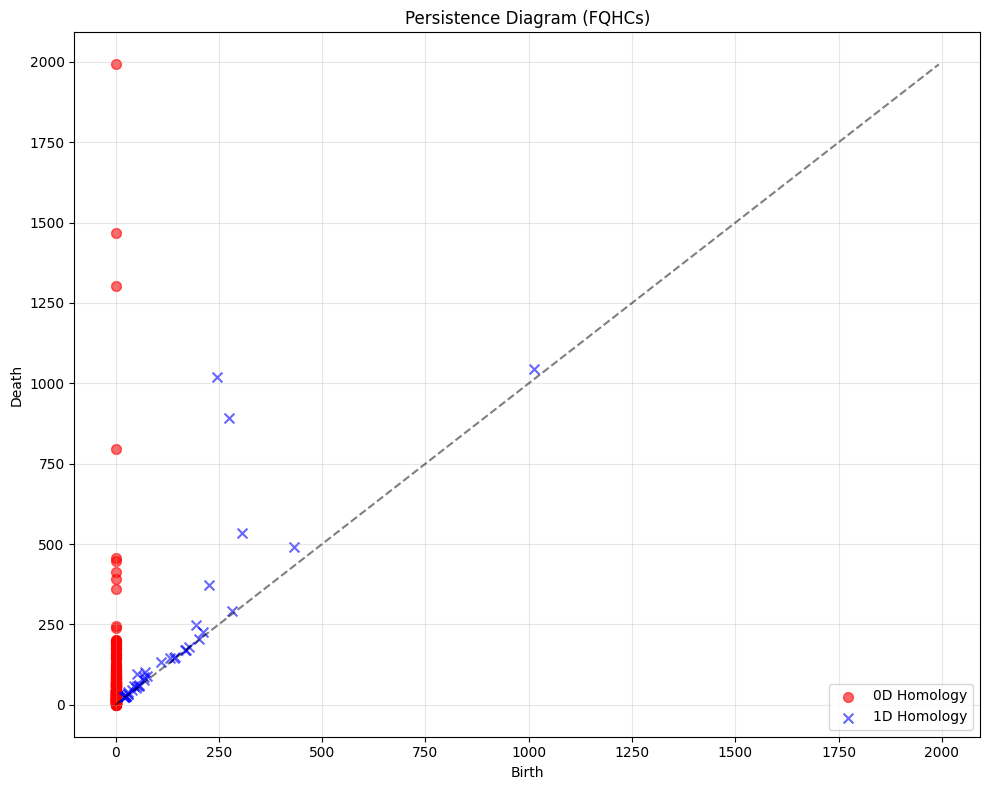

In [210]:
# 1. Plot persistence diagram
plot_persistence_diagram_fixed(ph)
plt.title(f"Persistence Diagram (FQHCs)")
plt.tight_layout()
plt.show()

### FQHC 0D Death Simplces 

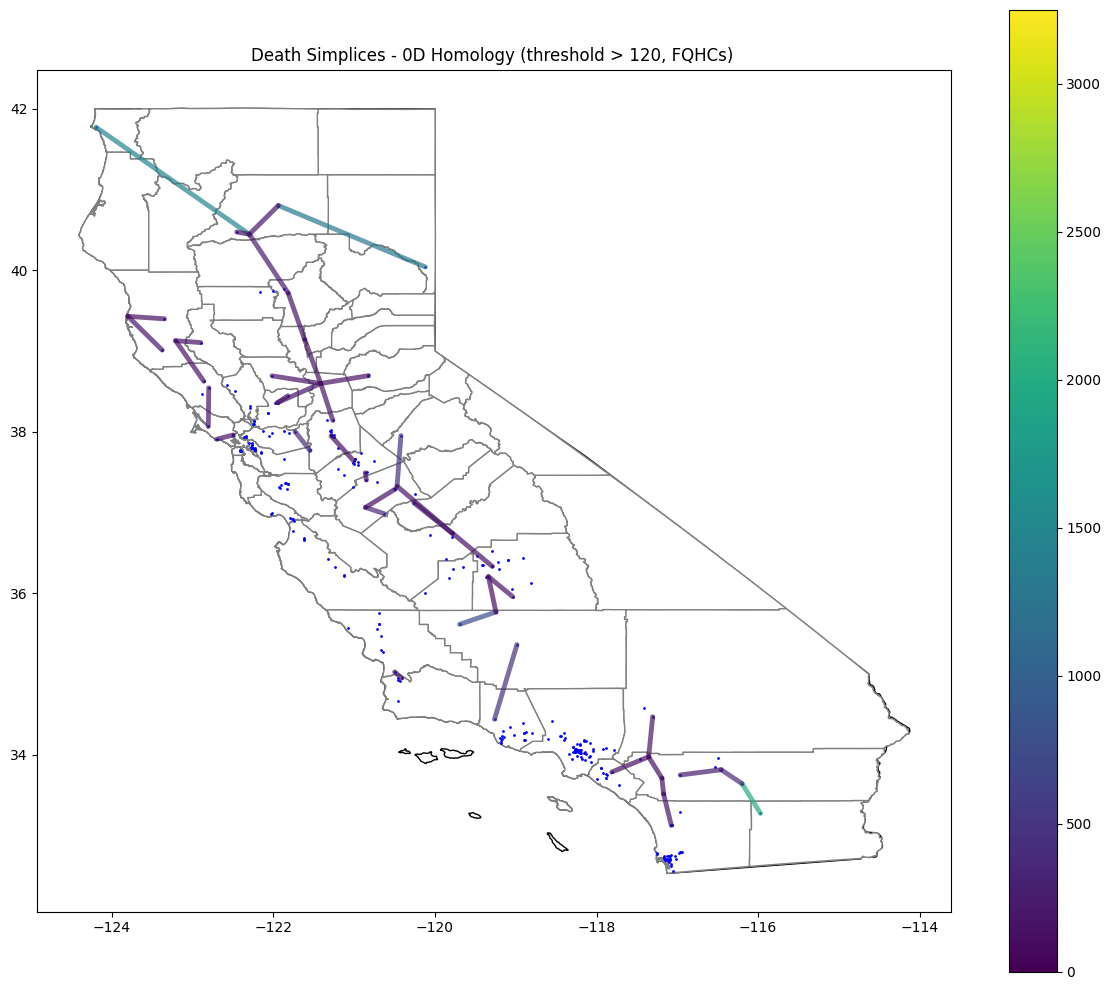

In [211]:
# 2. Plot 0D death simplices
fig, ax = plt.subplots(figsize=(12, 10))
california.plot(ax=ax, color='white', edgecolor='black')
plot_deathsimplices_raw(gdf, distance_matrix, cpx, all_pairs, 0, ax)
plt.title(f"Death Simplices - 0D Homology (threshold > {thresh}, FQHCs) ")
#simple_plot_death_simplices(gdf, cpx, all_pairs, hom_dim=0, ax=ax)
plt.tight_layout()
plt.show()

### 1D Death Simplices (FQHCs)

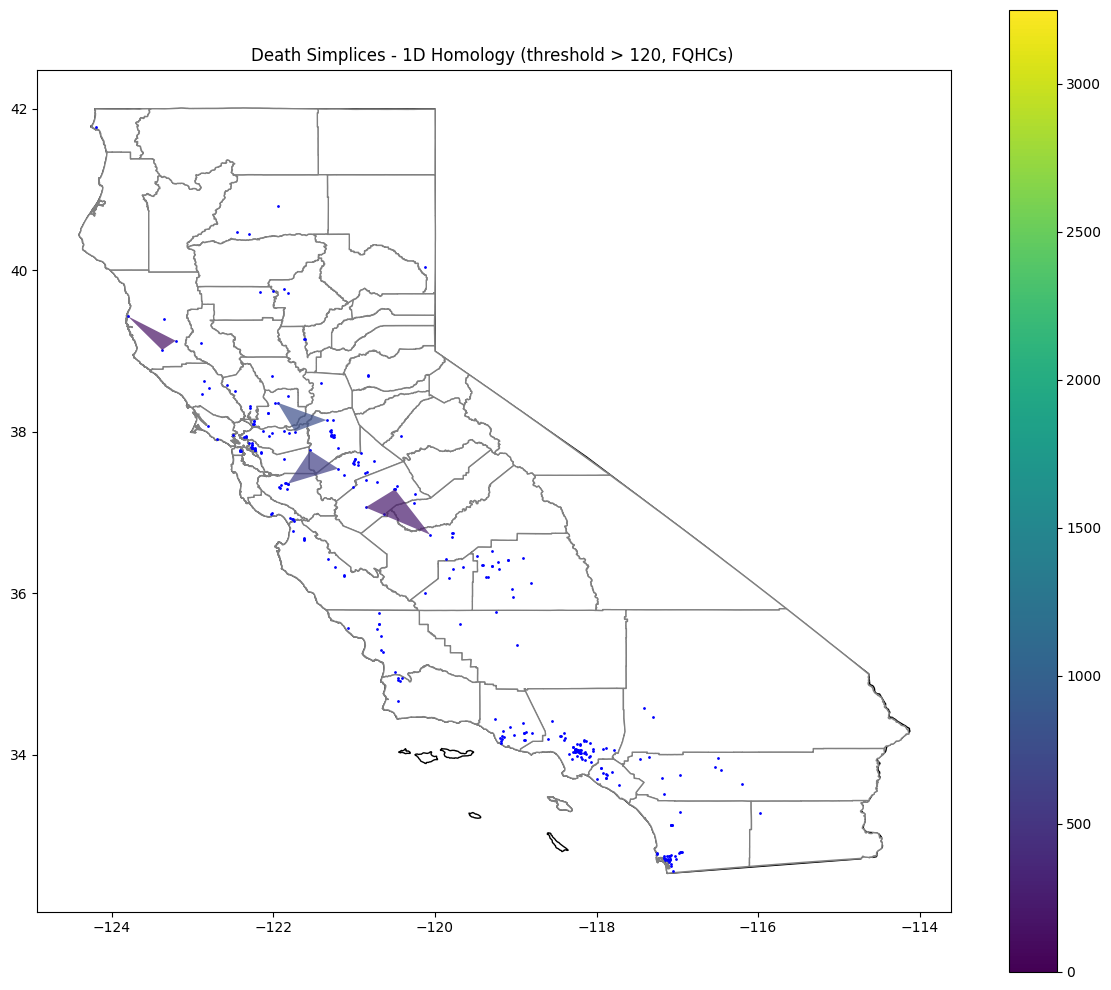

In [212]:
# 3. Plot 1D death simplices  
fig, ax = plt.subplots(figsize=(12, 10))
california.plot(ax=ax, color='white', edgecolor='black')
#simple_plot_death_simplices_raw(gdf, cpx, all_pairs, hom_dim=1, ax=ax)
#simple_plot_death_simplices(gdf, cpx, all_pairs, hom_dim=1, ax=ax)
plot_deathsimplices_raw(gdf, distance_matrix, cpx, all_pairs, 1, ax)
plt.title(f"Death Simplices - 1D Homology (threshold > {thresh}, FQHCs) ")
plt.tight_layout()
plt.show()